In [1]:
import os
os.chdir("../")

In [2]:
import argparse
import geopandas as gpd
from src.gelos_config import GELOSConfig
from src.downloader import Downloader
from src.aoi_processor import AOI_Processor
from pathlib import Path
import shutil
from src.utils.array import unique_class
import leafmap
import pandas as pd

In [3]:
import pdb
import xarray as xr
import rioxarray as rxr
from src.gelos_config import GELOSConfig
import pystac
import pandas as pd
import geopandas as gpd
import numpy as np
import stackstac

from src.utils.search import (
    search_s2_scenes, search_s1_scenes, search_landsat_scenes, get_landsat_wrs_path
)
from functools import reduce

In [4]:
config = "config.yml"
gelosconfig = GELOSConfig.from_yaml(config)
gelosconfig.dataset.version = 'test'
working_directory = Path(gelosconfig.directory.working) / gelosconfig.dataset.version

In [5]:
working_directory.mkdir(exist_ok=True)
# copy yaml to working directory
shutil.copy(config, working_directory / "config.yaml")

PosixPath('data/interim/data/test/config.yaml')

In [6]:
vars(gelosconfig)

{'dataset': DatasetConfig(version='test', fire=True),
 'aoi': AoiConfig(version='v0.20', include_indices=None, exclude_indices=None),
 'directory': DirectoryConfig(working='data/interim/data/', output='data/interim/data/test/final_data_v20_5/'),
 'log_errors': True,
 'sentinel_2': Sentinel2Config(collection='sentinel-2-l2a', resolution=10, native_crs=True, fill_na=False, na_value=-999, dtype=dtype('int16'), time_ranges=['2023-01-01/2023-03-31', '2023-04-01/2023-06-30', '2023-07-01/2023-09-30', '2023-10-01/2023-12-31'], nodata_pixel_percentage=5, cloud_cover=30, cloud_band='SCL', bands=['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12', 'SCL']),
 'sentinel_1': Sentinel1Config(collection='sentinel-1-rtc', resolution=10, native_crs=False, fill_na=False, na_value=-999, dtype=dtype('float32'), nodata_pixel_percentage=5, delta_days=12, bands=['vv', 'vh']),
 'landsat': LandsatConfig(collection='landsat-c2-l2', resolution=30, native_crs=False, fill_na=False, na

In [7]:
downloader = Downloader(gelosconfig)

In [8]:
# Initialize AOI processor with all necessary parameters
processor = AOI_Processor(
    aoi_index = 0,
    aoi = downloader.aoi_gdf.iloc[4],
    chip_index = downloader.chip_index,
    working_directory = downloader.working_directory,
    catalog = downloader.catalog,
    config = gelosconfig,
)

In [9]:
vars(processor)

{'config': GELOSConfig(dataset=DatasetConfig(version='test', fire=True), aoi=AoiConfig(version='v0.20', include_indices=None, exclude_indices=None), directory=DirectoryConfig(working='data/interim/data/', output='data/interim/data/test/final_data_v20_5/'), log_errors=True, sentinel_2=Sentinel2Config(collection='sentinel-2-l2a', resolution=10, native_crs=True, fill_na=False, na_value=-999, dtype=dtype('int16'), time_ranges=['2023-01-01/2023-03-31', '2023-04-01/2023-06-30', '2023-07-01/2023-09-30', '2023-10-01/2023-12-31'], nodata_pixel_percentage=5, cloud_cover=30, cloud_band='SCL', bands=['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B8A', 'B09', 'B11', 'B12', 'SCL']), sentinel_1=Sentinel1Config(collection='sentinel-1-rtc', resolution=10, native_crs=False, fill_na=False, na_value=-999, dtype=dtype('float32'), nodata_pixel_percentage=5, delta_days=12, bands=['vv', 'vh']), landsat=LandsatConfig(collection='landsat-c2-l2', resolution=30, native_crs=False, fill_na=False, na_valu

In [10]:
s2_items = pystac.item_collection.ItemCollection([])
for date_range in processor.config.sentinel_2.time_ranges:
    print(f"Searching Sentinel-2 scenes for {date_range}")
    s2_items_season, processor.s2_scene_id = search_s2_scenes(
        processor.aoi.geometry,
        date_range,
        processor.catalog,
        processor.config.sentinel_2.collection,
        processor.config.sentinel_2.nodata_pixel_percentage,
        processor.config.sentinel_2.cloud_cover,
        processor.s2_scene_id,
    )
    if not s2_items_season:
        raise ValueError("s2 scenes missing")
    s2_items += s2_items_season

Searching Sentinel-2 scenes for 2023-01-01/2023-03-31
Searching Sentinel-2 scenes for 2023-04-01/2023-06-30
Searching Sentinel-2 scenes for 2023-07-01/2023-09-30
Searching Sentinel-2 scenes for 2023-10-01/2023-12-31


In [11]:
s2_items

In [12]:
try:
    processor.epsg = s2_items[0].properties["proj:epsg"]
except:
    processor.epsg = int(s2_items[0].properties["proj:code"].split(":")[-1])
    
processor.s2_bbox = s2_items[0].geometry

In [13]:
processor.s2_bbox 

{'type': 'Polygon',
 'coordinates': [[[-120.454503, 38.7978946],
   [-119.1913473, 38.8284398],
   [-119.1617522, 37.8395955],
   [-120.4079147, 37.8101079],
   [-120.454503, 38.7978946]]]}

In [14]:
processor.landsat_wrs_path = get_landsat_wrs_path(processor.s2_bbox)

In [15]:
processor.landsat_wrs_path

43

In [16]:
landsat_wrs_path = '/home/benchuser/data/WRS2_descending_0.zip'
landsat_wrs_url = 'https://d9-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/atoms/files/WRS2_descending_0.zip'

In [17]:
landsat_wrs_gdf = gpd.read_file(landsat_wrs_url).to_crs(3857)

In [18]:
landsat_wrs_path_scenes = landsat_wrs_gdf[landsat_wrs_gdf['PATH'] == processor.landsat_wrs_path]

In [19]:
landsat_wrs_path_scenes.explore()

In [20]:
# search for landsat scenes
landsat_items = pystac.item_collection.ItemCollection([])

s2_item = s2_items[0]
date_range = processor.config.sentinel_2.time_ranges[0]

center_datetime = s2_item.datetime


aoi = processor.s2_bbox
center_datetime = center_datetime
overall_date_range = date_range
delta_days = processor.config.landsat.delta_days
catalog = processor.catalog
collection = processor.config.landsat.collection
platforms = processor.config.landsat.platforms
cloud_cover = processor.config.landsat.cloud_cover
landsat_wrs_path = processor.landsat_wrs_path
print(f'{aoi=}')
print(f'{center_datetime=}')
print(f'{overall_date_range=}')
print(f'{delta_days=}')
print(f'{catalog=}')
print(f'{collection=}')
print(f'{platforms=}')
print(f'{cloud_cover=}')
print(f'{landsat_wrs_path=}')


aoi={'type': 'Polygon', 'coordinates': [[[-120.454503, 38.7978946], [-119.1913473, 38.8284398], [-119.1617522, 37.8395955], [-120.4079147, 37.8101079], [-120.454503, 38.7978946]]]}
center_datetime=datetime.datetime(2023, 3, 2, 18, 43, 9, 25000, tzinfo=tzutc())
overall_date_range='2023-01-01/2023-03-31'
delta_days=91
catalog=<Client id=microsoft-pc>
collection='landsat-c2-l2'
platforms=['landsat-8', 'landsat-9']
cloud_cover=30
landsat_wrs_path=43


In [21]:
processor.stacks

{}

In [22]:
from src.utils.search import get_clipped_datetime_range
datetime_range = get_clipped_datetime_range(center_datetime, overall_date_range, delta_days)

In [23]:
datetime_range

'2023-01-01T00:00:00Z/2023-03-31T23:59:59Z'

In [24]:
query = {
        "platform": {"in": platforms},
        "eo:cloud_cover": {"lt": cloud_cover},
    }
# if landsat_wrs_path:
#     query["landsat:wrs_path"] = {"eq": landsat_wrs_path}
print(query)

{'platform': {'in': ['landsat-8', 'landsat-9']}, 'eo:cloud_cover': {'lt': 30}}


In [25]:
search = catalog.search(
    collections = collection,
    intersects = aoi,
    datetime = datetime_range,
    query = query,
    sortby = ["+properties.eo:cloud_cover"],
    max_items = 50 
)

In [26]:
search

In [27]:
items = search.item_collection()

In [28]:
items

In [29]:
landsat_items = pystac.item_collection.ItemCollection([])

for s2_item, date_range in zip(s2_items, processor.config.sentinel_2.time_ranges):
    center_datetime = s2_item.datetime
 
    landsat_item = search_landsat_scenes(
        processor.s2_bbox,
        center_datetime,
        date_range,
        processor.config.landsat.delta_days,
        processor.catalog,
        processor.config.landsat.collection,
        processor.config.landsat.platforms,
        processor.config.landsat.cloud_cover,
        processor.landsat_wrs_path,
    )
    landsat_items += landsat_item
    break


In [30]:
s1_items = pystac.item_collection.ItemCollection([])

for s2_item, date_range in zip(s2_items, processor.config.sentinel_2.time_ranges):
    center_datetime = s2_item.datetime
    print(f"searching sentinel_1 and landsat scenes close to {center_datetime} within {date_range}")
    print({
        's2_bbox': processor.s2_bbox,
        'center_datetime': center_datetime,
        'date_range': date_range,
        'delta_days': processor.config.sentinel_1.delta_days,
        'catalog': processor.catalog,
        'collection': processor.config.sentinel_1.collection,
        's1_relative_orbit': processor.s1_relative_orbit,
    })
    s1_item, processor.s1_relative_orbit = search_s1_scenes(
        processor.s2_bbox,
        center_datetime,
        date_range,
        processor.config.sentinel_1.delta_days,
        processor.catalog,
        processor.config.sentinel_1.collection,
        processor.s1_relative_orbit,
    )
    s1_items += s1_item

searching sentinel_1 and landsat scenes close to 2023-03-02 18:43:09.025000+00:00 within 2023-01-01/2023-03-31
{'s2_bbox': {'type': 'Polygon', 'coordinates': [[[-120.454503, 38.7978946], [-119.1913473, 38.8284398], [-119.1617522, 37.8395955], [-120.4079147, 37.8101079], [-120.454503, 38.7978946]]]}, 'center_datetime': datetime.datetime(2023, 3, 2, 18, 43, 9, 25000, tzinfo=tzutc()), 'date_range': '2023-01-01/2023-03-31', 'delta_days': 12, 'catalog': <Client id=microsoft-pc>, 'collection': 'sentinel-1-rtc', 's1_relative_orbit': None}
searching sentinel_1 and landsat scenes close to 2023-06-30 18:39:29.024000+00:00 within 2023-04-01/2023-06-30
{'s2_bbox': {'type': 'Polygon', 'coordinates': [[[-120.454503, 38.7978946], [-119.1913473, 38.8284398], [-119.1617522, 37.8395955], [-120.4079147, 37.8101079], [-120.454503, 38.7978946]]]}, 'center_datetime': datetime.datetime(2023, 6, 30, 18, 39, 29, 24000, tzinfo=tzutc()), 'date_range': '2023-04-01/2023-06-30', 'delta_days': 12, 'catalog': <Client

In [31]:
landsat_items

In [32]:
s1_items

In [33]:
aoi

{'type': 'Polygon',
 'coordinates': [[[-120.454503, 38.7978946],
   [-119.1913473, 38.8284398],
   [-119.1617522, 37.8395955],
   [-120.4079147, 37.8101079],
   [-120.454503, 38.7978946]]]}

In [34]:
from src.utils.search import get_fire_date_ranges

event_date_ranges, control_date_ranges = get_fire_date_ranges(
                                                        downloader.aoi_gdf.iloc[4], 
                                                        n_control_years=getattr(
                                                        gelosconfig.dataset.fire, 
                                                        "n_control_years", 
                                                        7)
                                                    )

In [35]:
downloader.aoi_gdf.iloc[4]

source                                                    MTBS
location                                               TILTILL
pre_date                                   2021-07-13 00:00:00
post_date                                  2022-07-16 00:00:00
status                                           not processed
geometry     POLYGON ((-119.68919957919718 37.9917567670611...
Name: 4, dtype: object

In [36]:
# Initialize the fire chip generator
# fire_chip_generator = FireChipGenerator(str(working_directory))

In [37]:
print("Event Date Ranges::", event_date_ranges)
print("Control Date Ranges::", control_date_ranges)


Event Date Ranges:: ['2022-01-01/2022-03-31', '2022-04-01/2022-06-30', '2022-07-01/2022-09-30', '2022-10-01/2022-12-31']
Control Date Ranges:: [['2021-01-01/2021-03-31', '2021-04-01/2021-06-30', '2021-07-01/2021-09-30', '2021-10-01/2021-12-31'], ['2020-01-01/2020-03-31', '2020-04-01/2020-06-30', '2020-07-01/2020-09-30', '2020-10-01/2020-12-31'], ['2019-01-01/2019-03-31', '2019-04-01/2019-06-30', '2019-07-01/2019-09-30', '2019-10-01/2019-12-31'], ['2018-01-01/2018-03-31', '2018-04-01/2018-06-30', '2018-07-01/2018-09-30', '2018-10-01/2018-12-31'], ['2017-01-01/2017-03-31', '2017-04-01/2017-06-30', '2017-07-01/2017-09-30', '2017-10-01/2017-12-31'], ['2016-01-01/2016-03-31', '2016-04-01/2016-06-30', '2016-07-01/2016-09-30', '2016-10-01/2016-12-31'], ['2015-01-01/2015-03-31', '2015-04-01/2015-06-30', '2015-07-01/2015-09-30', '2015-10-01/2015-12-31']]


In [38]:
metadata_df = pd.DataFrame(columns=["chip_index", "aoi_index", "date", "type","source", "platform", "x_center", "y_center", "epsg", "pre_date", "post_date", "chip_footprint", "status"])

In [39]:
# # Test the AOI processor with the fire pipeline
# try:
#     # Get fire event and control dates
#     event_date_ranges, control_date_ranges = get_fire_date_ranges(
#         downloader.aoi_gdf.iloc[4],
#         n_control_years=getattr(gelosconfig.dataset.fire, "n_control_years", 7)
#     )
    
#     # Process event period
#     print("Processing event period...")
#     new_chip_gdf = processor.process_aoi(
#         time_series_type="event",
#         time_ranges=event_date_ranges,
#         metadata_df=metadata_df
#     )
    
#     if not new_chip_gdf.empty:
#         print("Successfully generated event chips")
#         # Update chip index for next operations
#         processor.chip_index += len(new_chip_gdf)
#     else:
#         print("Failed to generate event chips - no valid locations found")
    
#     # Process control periods
#     for ctrl_dates in control_date_ranges:
#         try:
#             print(f"\nProcessing control period: {ctrl_dates}")
#             control_chip_gdf = processor.process_aoi(
#                 time_series_type="control",
#                 time_ranges=[ctrl_dates],
#                 metadata_df=metadata_df
#             )
            
#             if not control_chip_gdf.empty:
#                 print("Successfully generated control chips")
#                 new_chip_gdf = pd.concat([new_chip_gdf, control_chip_gdf], ignore_index=True)
#                 # Update chip index
#                 processor.chip_index += len(control_chip_gdf)
#             else:
#                 print("Failed to generate control chips - no valid locations found")
                
#         except Exception as e:
#             print(f"Error processing control period: {str(e)}")
#             continue
            
# except Exception as e:
#     print(f"Error processing AOI: {str(e)}")
#     import traceback
#     print("Full error:")
#     print(traceback.format_exc())
#     new_chip_gdf = pd.DataFrame()

# # Save metadata if we have any successful chips
# if not new_chip_gdf.empty:
#     new_chip_gdf.to_csv(working_directory / "metadata.csv", index=False)

In [40]:
# Check S2 data and stacks before processing
print("S2 items:", len(s2_items))
print("Current stacks in processor:", list(processor.stacks.keys()))
print("Processor EPSG:", processor.epsg)
print("Processor AOI bounds:", processor.aoi.geometry.bounds)

S2 items: 4
Current stacks in processor: []
Processor EPSG: 32611
Processor AOI bounds: (-119.72282507042064, 37.97326546832676, -119.67500509820667, 38.03099261231927)


In [41]:
new_chip_gdf = processor.process_aoi(
        time_series_type="event",
        time_ranges=event_date_ranges,
        metadata_df=metadata_df
    )


Processing AOI at index 0
Searching Sentinel-2 scenes for 2022-01-01/2022-03-31
Searching Sentinel-2 scenes for 2022-04-01/2022-06-30
Searching Sentinel-2 scenes for 2022-07-01/2022-09-30
Searching Sentinel-2 scenes for 2022-10-01/2022-12-31
searching sentinel_1 and landsat scenes close to 2022-02-25 18:43:39.024000+00:00 within 2022-01-01/2022-03-31
searching sentinel_1 and landsat scenes close to 2022-06-15 18:39:19.024000+00:00 within 2022-04-01/2022-06-30
searching sentinel_1 and landsat scenes close to 2022-09-23 18:41:09.024000+00:00 within 2022-07-01/2022-09-30
searching sentinel_1 and landsat scenes close to 2022-10-13 18:43:29.024000+00:00 within 2022-10-01/2022-12-31
stacking landsat data...
stacking sentinel_1 data...
stacking sentinel_2 data...
Generating event chips for AOI 0
Extracting burn-rich chip areas from event stack for landsat
  landsat: 15 chip locations
Extracting burn-rich chip areas from event stack for sentinel_1
  sentinel_1: 15 chip locations
Extracting bu

In [42]:
new_chip_gdf

chip_index aoi_index      date   type source    platform  \
0    00000_00_e_20220120         0  20220120  event   MTBS     landsat   
1    00000_00_e_20220629         0  20220629  event   MTBS     landsat   
2    00000_00_e_20220901         0  20220901  event   MTBS     landsat   
3    00000_00_e_20221003         0  20221003  event   MTBS     landsat   
4    00000_00_e_20220223         0  20220223  event   MTBS  sentinel_1   
..                   ...       ...       ...    ...    ...         ...   
175  00000_14_e_20221009         0  20221009  event   MTBS  sentinel_1   
176  00000_14_e_20220225         0  20220225  event   MTBS  sentinel_2   
177  00000_14_e_20220615         0  20220615  event   MTBS  sentinel_2   
178  00000_14_e_20220923         0  20220923  event   MTBS  sentinel_2   
179  00000_14_e_20221013         0  20221013  event   MTBS  sentinel_2   

     x_center   y_center   epsg             pre_date            post_date  \
0    264615.0  4212045.0  32611  2021-07-13 00:00:00  2022-07-16 00:00:00   
1    264615.0  4212045.0  32611  2021-07-13 00:00:00  2022-07-16 00:00:00   
2    264615.0  4212045.0  32611  2021-07-13 00:00:00  2022-07-16 00:00:00   
3    264615.0  4212045.0  32611  2021-07-13 00:00:00  2022-07-16 00:00:00   
4    264605.0  4212055.0  32611  2021-07-13 00:00:00  2022-07-16 00:00:00   
..        ...        ...    ...                  ...                  ...   
175  262685.0  4206295.0  32611  2021-07-13 00:00:00  2022-07-16 00:00:00   
176  262685.0  4206295.0  32611  2021-07-13 00:00:00  2022-07-16 00:00:00   
177  262685.0  4206295.0  32611  2021-07-13 00:00:00  2022-07-16 00:00:00   
178  262685.0  4206295.0  32611  2021-07-13 00:00:00  2022-07-16 00:00:00   
179  262685.0  4206295.0  32611  2021-07-13 00:00:00  2022-07-16 00:00:00   

                                        chip_footprint   status  
0    POLYGON ((-119.67625200180248 38.0214880771732...  success  
1    POLYGON ((-119.67625200180248 38.0214880771732...  success  
2    POLYGON ((-119.67625200180248 38.0214880771732...  success  
3    POLYGON ((-119.67625200180248 38.0214880771732...  success  
4    POLYGON ((-119.67625200180248 38.0214880771732...  success  
..                                                 ...      ...  
175  POLYGON ((-119.69620240913913 37.9691316666871...  success  
176  POLYGON ((-119.69620240913913 37.9691316666871...  success  
177  POLYGON ((-119.69620240913913 37.9691316666871...  success  
178  POLYGON ((-119.69620240913913 37.9691316666871...  success  
179  POLYGON ((-119.69620240913913 37.9691316666871...  success  

[180 rows x 13 columns]

In [44]:
processor.stacks['sentinel_2']

<xarray.DataArray 'stackstac-f964c61c73fa3d544426ae98b7774434' (time: 4,
                                                                band: 12,
                                                                y: 5913,
                                                                x: 10056)> Size: 23GB
dask.array<getitem, shape=(4, 12, 5913, 10056), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/39)
  * time                                     (time) datetime64[ns] 32B 2022-0...
    id                                       (time) <U54 864B 'S2B_MSIL2A_202...
  * band                                     (band) <U3 144B 'B01' ... 'B12'
  * x                                        (x) float64 80kB 1.979e+05 ... 2...
  * y                                        (y) float64 47kB 4.25e+06 ... 4....
    platform                                 <U11 44B 'Sentinel-2B'
    ...                                       ...
    s2:vegetation_percentage                 (time) float64 32B 16.8 ... 42.32
    s2:not_vegetated_percentage              (time) float64 32B 15.69 ... 55.23
    eo:cloud_cover                           (time) float64 32B 0.236 ... 0.0...
    s2:snow_ice_percentage                   (time) float64 32B 64.89 ... 0.0...
    proj:bbox                                object 8B {199980.0, 4300020.0, ...
    epsg                                     int64 8B 32611
Attributes:
    spec:        RasterSpec(epsg=32611, bounds=(197880, 4190850, 298440, 4249...
    crs:         epsg:32611
    transform:   | 10.00, 0.00, 197880.00|\n| 0.00,-10.00, 4249980.00|\n| 0.0...
    resolution:  10
    _FillValue:  -999.0

In [45]:
processor.stacks['landsat']

<xarray.DataArray 'stackstac-6ca92a6e140175906c1362bb68abbabc' (time: 4,
                                                                band: 7,
                                                                y: 1971, x: 3352)> Size: 1GB
dask.array<getitem, shape=(4, 7, 1971, 3352), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/16)
  * band                         (band) <U8 224B 'coastal' 'blue' ... 'swir22'
  * x                            (x) float64 27kB 1.979e+05 ... 2.984e+05
  * y                            (y) float64 16kB 4.25e+06 ... 4.191e+06
    gsd                          int64 8B 30
    platform                     <U9 36B 'landsat-9'
    sci:doi                      <U16 64B '10.5066/P9OGBGM6'
    ...                           ...
    landsat:collection_category  <U2 8B 'T1'
    view:off_nadir               int64 8B 0
    landsat:wrs_path             <U3 12B '043'
    landsat:correction           <U4 16B 'L2SP'
    epsg                         int64 8B 32611
  * time                         (time) datetime64[ns] 32B 2022-01-20T18:39:4...
Attributes:
    spec:        RasterSpec(epsg=32611, bounds=(197880, 4190850, 298440, 4249...
    crs:         epsg:32611
    transform:   | 30.00, 0.00, 197880.00|\n| 0.00,-30.00, 4249980.00|\n| 0.0...
    resolution:  30
    _FillValue:  -999.0

In [44]:
import xarray as xr
import rioxarray as rxr

def grid_sig(da):
    A = da.rio.transform()
    return (da.rio.crs.to_string(), A.a, A.b, A.c, A.d, A.e, A.f)

print("S2 grid:", grid_sig(processor.stacks['sentinel_2']))
print("L8 grid:", grid_sig(processor.stacks['landsat']))
print("S1 grid:", grid_sig(processor.stacks['sentinel_1']))


S2 grid: ('EPSG:32611', 10.0, 0.0, 197880.0, 0.0, -10.0, 4249980.0)
L8 grid: ('EPSG:32611', 30.0, 0.0, 197880.0, 0.0, -30.0, 4249980.0)
S1 grid: ('EPSG:32611', 10.0, 0.0, 197880.0, 0.0, -10.0, 4249980.0)


In [ ]:
# Check for NaNs in stacks
for platform, stack in processor.stacks.items():
    if stack is None:
        print(f"Stack for {platform} is None")
        continue
    if np.isnan(stack).any():
        print(f"WARNING: NaN values found in {platform} stack")
    else:
        print(f"No NaN values in {platform} stack")
    print(f"{platform} stack shape: {stack.shape}, coords: {list(stack.coords)}")

In [ ]:
import xarray as xr
import rioxarray as rxr
import numpy as np

def analyze_grid_alignment(stacks):
    def grid_sig(da):
        A = da.rio.transform()
        return (da.rio.crs.to_string(), A.a, A.b, A.c, A.d, A.e, A.f)
    
    print("=== Grid Analysis ===")
    for name, da in stacks.items():
        sig = grid_sig(da)
        print(f"\n{name} grid:")
        print(f"CRS: {sig[0]}")
        print(f"Resolution: ({abs(sig[1])}, {abs(sig[4])}) meters")
        print(f"Origin: ({sig[2]}, {sig[5]})")
        
        # Check alignment with base 10m grid
        x_align_10m = sig[2] % 10
        y_align_10m = sig[5] % 10
        print(f"Alignment with 10m grid: x_offset={x_align_10m}m, y_offset={y_align_10m}m")
        
        if abs(sig[1]) > 10:  # For Landsat
            x_align_30m = sig[2] % 30
            y_align_30m = sig[5] % 30
            print(f"Alignment with 30m grid: x_offset={x_align_30m}m, y_offset={y_align_30m}m")

# Run analysis
analyze_grid_alignment(processor.stacks)

In [51]:
# Process control periods with AOI_Processor
for time_ranges in control_date_ranges:
    for ctrl_dates in time_ranges:
        try:
            print(f"\nProcessing control period: {ctrl_dates}")
            
            # Process control period using AOI_Processor
            control_chip_gdf = processor.process_aoi(
                time_series_type="control",
                time_ranges=[ctrl_dates],  # Wrap single date range in list
                metadata_df=metadata_df
            )
            
            if not control_chip_gdf.empty:
                print("Successfully generated control chips")
                new_chip_gdf = pd.concat([new_chip_gdf, control_chip_gdf], ignore_index=True)
            else:
                print("Failed to generate control chips - no valid locations found")
                    
        except Exception as e:
            print(f"Error processing control period: {str(e)}")
            continue

# Save metadata
if not new_chip_gdf.empty:
    new_chip_gdf.to_csv(working_directory / "metadata.csv", index=False)


Processing control period: 2021-01-01/2021-03-31

Processing AOI at index 0
Searching Sentinel-2 scenes for 2021-01-01/2021-03-31
Error processing control period: S2 scenes missing

Processing control period: 2021-04-01/2021-06-30

Processing AOI at index 0
Searching Sentinel-2 scenes for 2021-04-01/2021-06-30
Error processing control period: S2 scenes missing

Processing control period: 2021-07-01/2021-09-30

Processing AOI at index 0
Searching Sentinel-2 scenes for 2021-07-01/2021-09-30
Error processing control period: S2 scenes missing

Processing control period: 2021-10-01/2021-12-31

Processing AOI at index 0
Searching Sentinel-2 scenes for 2021-10-01/2021-12-31
Error processing control period: S2 scenes missing

Processing control period: 2020-01-01/2020-03-31

Processing AOI at index 0
Searching Sentinel-2 scenes for 2020-01-01/2020-03-31
Error processing control period: S2 scenes missing

Processing control period: 2020-04-01/2020-06-30

Processing AOI at index 0
Searching Sen

In [ ]:
new_chip_gdf

### Visualize Sample Chips

In [52]:
print(gelosconfig.directory.output)

data/interim/data/test/final_data_v20_5/


In [54]:
!ls data/interim/data/test/final_data_v20_5/

landsat_00000_00_e_20220120.tif     sentinel_1_00000_07_e_20220927.tif
landsat_00000_00_e_20220629.tif     sentinel_1_00000_07_e_20221009.tif
landsat_00000_00_e_20220901.tif     sentinel_1_00000_08_e_20220223.tif
landsat_00000_00_e_20221003.tif     sentinel_1_00000_08_e_20220611.tif
landsat_00000_01_e_20220120.tif     sentinel_1_00000_08_e_20220927.tif
landsat_00000_01_e_20220629.tif     sentinel_1_00000_08_e_20221009.tif
landsat_00000_01_e_20220901.tif     sentinel_1_00000_09_e_20220223.tif
landsat_00000_01_e_20221003.tif     sentinel_1_00000_09_e_20220611.tif
landsat_00000_02_e_20220120.tif     sentinel_1_00000_09_e_20220927.tif
landsat_00000_02_e_20220629.tif     sentinel_1_00000_09_e_20221009.tif
landsat_00000_02_e_20220901.tif     sentinel_1_00000_10_e_20220223.tif
landsat_00000_02_e_20221003.tif     sentinel_1_00000_10_e_20220611.tif
landsat_00000_03_e_20220120.tif     sentinel_1_00000_10_e_20220927.tif
landsat_00000_03_e_20220629.tif     sentinel_1_00000_10_e_20221009.tif
landsa

In [69]:
import os
import re
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
import rasterio

# Find all generated chips
pattern = re.compile(r"sentinel_2_(\w+)_(\w+)_(\d{8})\.tif")
files_by_id = defaultdict(list)
working_directory = gelosconfig.directory.output  # Path or pathlib.Path
# working_directory = "/workspace/Rufai/gfm-bench/data/interim/final_data_v20_5"

for filename in os.listdir(working_directory):
    match = pattern.match(filename)
    if match:
        id_ = match.group(1)
        time_series_type = match.group(2)
        date = match.group(3)
        full_path = os.path.join(working_directory, filename)
        files_by_id[id_].append((date, time_series_type, full_path))

def read_rgb_stretched(path, bands=(4, 3, 2), low=2, high=98, gamma=1.0):
    """Read BGR (1-based band indices), auto-scale to [0,1] with percentile stretch."""
    with rasterio.open(path) as src:
        arr = src.read(bands, masked=True).astype(np.float32)  # shape: (3, H, W)

        # If scale is obviously 0–10000 (uint16 reflectance), normalize; else detect
        finite = np.isfinite(arr)
        vmax = np.nanmax(np.where(finite, arr, np.nan))
        if vmax > 100:
            arr = arr / 10000.0

        # Percentile stretch per band, ignoring NaNs
        out = np.empty_like(arr, dtype=np.float32)
        for i in range(arr.shape[0]):
            band = arr[i]
            
            # Compute robust min/max
            p_low = np.nanpercentile(band, low)
            p_high = np.nanpercentile(band, high)
            if not np.isfinite(p_low) or not np.isfinite(p_high) or p_high <= p_low:
                # Fallback to min/max if percentiles are degenerate
                p_low = np.nanmin(band)
                p_high = np.nanmax(band) if np.nanmax(band) > p_low else p_low + 1e-6

            # Stretch and clip to [0,1]
            stretched = (band - p_low) / (p_high - p_low)
            stretched = np.clip(stretched, 0.0, 1.0)
            out[i] = stretched

        # apply gamma
        if gamma != 1.0:
            out = np.clip(out, 0.0, 1.0) ** (1.0 / gamma)

        # convert back to HxWx3
        rgb = np.transpose(out, (1, 2, 0))
        # Replace NaNs with 0 for display
        rgb = np.nan_to_num(rgb, nan=0.0)
        return rgb

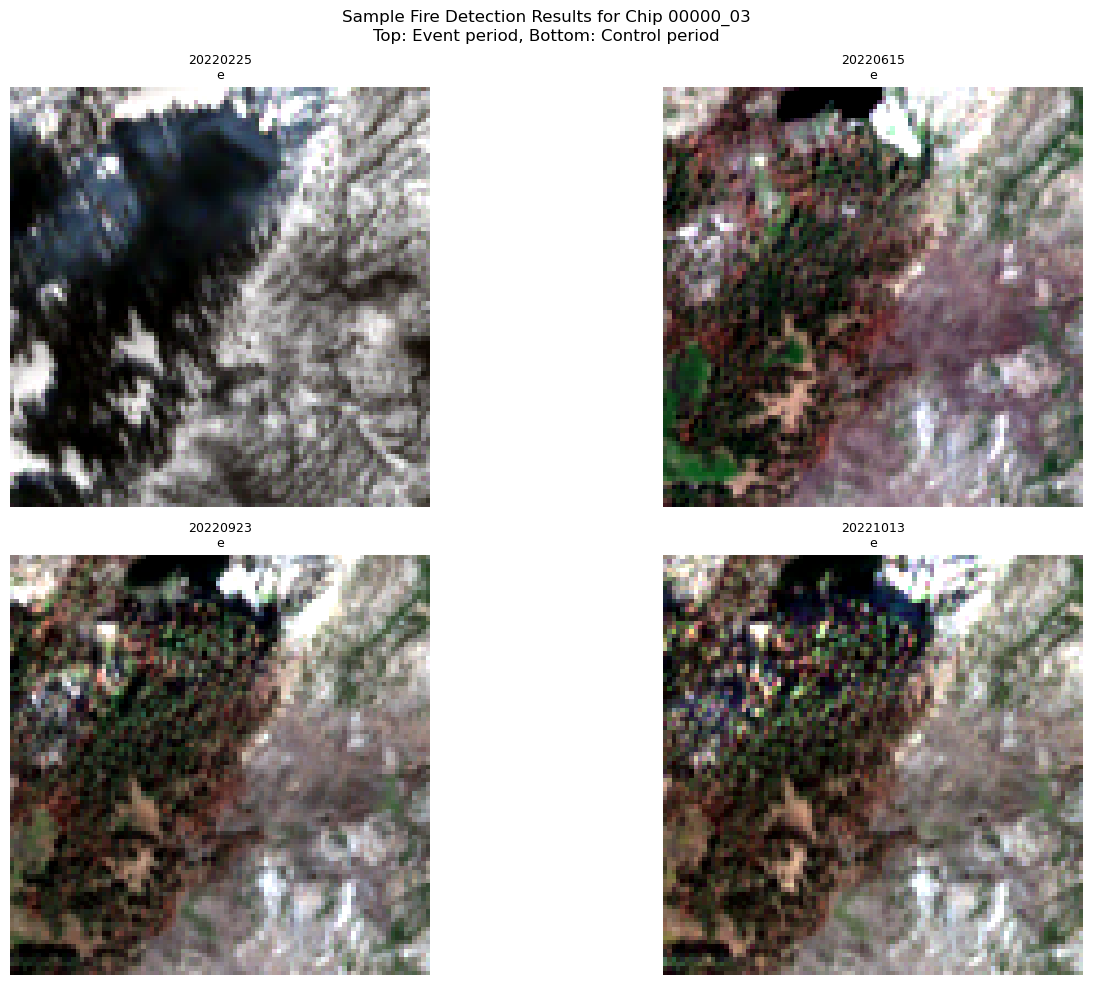

In [70]:
# create visualization of a sample chip
if files_by_id:
    sample_id = list(files_by_id.keys())[0]
    scenes = sorted(files_by_id[sample_id], key=lambda x: (x[1], x[0]))

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(
        f"Sample Fire Detection Results for Chip {sample_id}\nTop: Event period, Bottom: Control period",
        fontsize=12
    )
    axes = axes.ravel()

    for i, (date, ts_type, path) in enumerate(scenes[:4]):
        rgb = read_rgb_stretched(path, bands=(4, 3, 2), low=2, high=98, gamma=1.0)
        axes[i].imshow(rgb)
        axes[i].set_title(f"{date}\n{ts_type}", fontsize=9)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No chips found for visualization")